In [1]:
from geotiff import GeoTiff
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
master = pd.read_csv('Master_Data_Frame_cleaned.csv')
master.columns

Index(['Unnamed: 0', 'Year', 'Mo', 'Dy', 'Hr', 'Country', 'Region',
       'Focal Depth (km)', 'Mag', 'Average Income', 'p0p50_share',
       'Population density national', 'Total Deaths', 'Total Injuries',
       'Total Damage ($Mil)', 'Total Houses Destroyed', 'Total Houses Damaged',
       'Total Death Description', 'Total Injuries Description',
       'Total Damage Description', 'Total Houses Destroyed Description',
       'Total Houses Damaged Description'],
      dtype='object')

In [3]:
master[['Year', 'Latitude', 'Longitude', 'Mag']]

KeyError: "['Latitude', 'Longitude'] not in index"

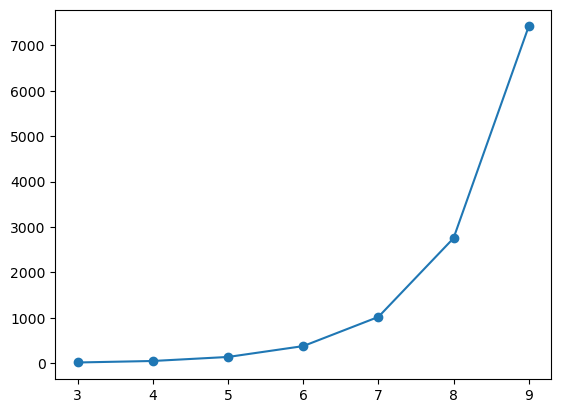

In [21]:
mag_rad_data = np.array(
    [[3, 4, 5, 6, 7, 8, 9],
     [19.5, 52.5, 141, 380, 1022, 2754, 7413]]
)

plt.plot(mag_rad_data[0], mag_rad_data[1], 'o-')

In [22]:
master['preperation_zone'] = np.interp(master['Mag'], mag_rad_data[0], mag_rad_data[1])
master['preperation_zone'].fillna(np.nanmean(master['preperation_zone']), inplace=True)

/var/folders/wr/nnzrl8p15wd8_8sccj0_s_rc0000gn/T/ipykernel_54132/3522916562.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master['preperation_zone'].fillna(np.nanmean(master['preperation_zone']), inplace=True)


In [23]:
index = 172 # 295, 172, 591
master.loc[index]

Year                                                                         2004
Mo                                                                             12
Dy                                                                             26
Hr                                                                            0.0
Mn                                                                           58.0
Sec                                                                          53.5
Tsu                                                                        2439.0
Vol                                                                           NaN
Country                                                                 INDONESIA
Location Name                         INDONESIA:  SUMATRA:  ACEH:  OFF WEST COAST
Latitude                                                                    3.295
Longitude                                                                  95.982
Focal Depth (km)

In [24]:
lat = master.loc[index].Latitude
lon = master.loc[index].Longitude
rad = master.loc[index].preperation_zone
year = master.loc[index].Year
file = f'pop_regional_data/ppp_{year}_1km_Aggregated.tif'

In [25]:
pop_data = GeoTiff(file)
print(pop_data.crs_code)
x_index = pop_data._get_x_int(lon)
y_index = pop_data._get_y_int(lat)
x_min = x_index - int(rad)
x_max = x_index + int(rad)
y_min = y_index - int(rad)
y_max = y_index + int(rad)
box = [pop_data.get_wgs_84_coords(x_min, y_min), pop_data.get_wgs_84_coords(x_max, y_max)]

4326


In [26]:
box_data = np.array(pop_data.read_box(box), dtype='float64')
ave_pop = np.mean(box_data)
ave_pop

-2.1004251026358632e+38

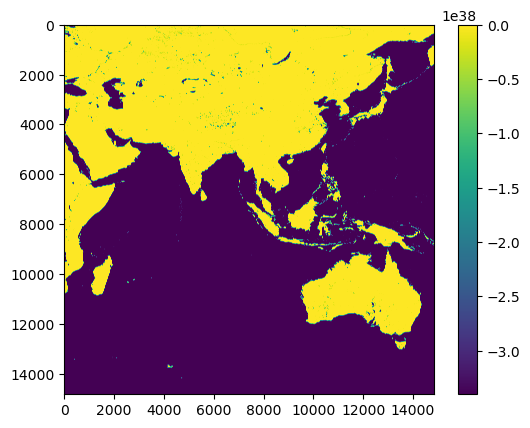

In [27]:
scat = plt.imshow(box_data)
fig = plt.gcf()
ax = plt.gca()
fig.colorbar(scat)

In [28]:
box_data[box_data >= 10e10] = 0
box_data[box_data <= 0] = 0

ave_pop = np.mean(box_data)
ave_pop

18.82373009663436

(-0.5, 14824.5, 14825.5, -0.5)

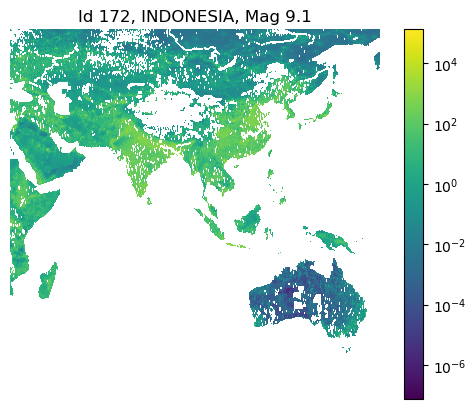

In [37]:
scat = plt.imshow(box_data, norm=colors.LogNorm(clip=True))
fig = plt.gcf()
ax = plt.gca()
fig.colorbar(scat)
ax.set_title(f'Id {index}, {master.loc[index].Country}, Mag {master.loc[index].Mag}')
ax.axis('off')

In [30]:
box_data[box_data >= 10e10] = 'NaN'
box_data[box_data <= 0] = 'NaN'

ave_pop = np.nanmean(box_data)
ave_pop

51.13131445373295

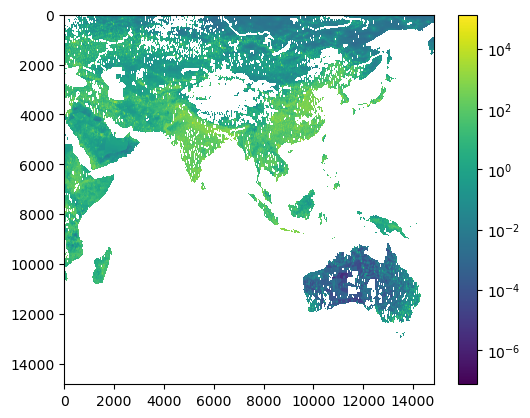

In [31]:
scat = plt.imshow(box_data, norm=colors.LogNorm())
fig = plt.gcf()
ax = plt.gca()
fig.colorbar(scat)

In [17]:
pop_with_water = []
pop_without_water = []
pop_total = []

for i, row in master.iterrows():
    lat = row.Latitude
    lon = row.Longitude
    rad = row.preperation_zone
    year = row.Year
    file = f'pop_regional_data/ppp_{year}_1km_Aggregated.tif'

    pop_data = GeoTiff(file)
    x_index = pop_data._get_x_int(lon)
    y_index = pop_data._get_y_int(lat)
    x_min = x_index - int(rad)
    x_max = x_index + int(rad)
    y_min = y_index - int(rad)
    y_max = y_index + int(rad)
    box = [pop_data.get_wgs_84_coords(x_min, y_min), pop_data.get_wgs_84_coords(x_max, y_max)]

    box_data = np.array(pop_data.read_box(box), dtype='float64')
    box_data2 = box_data.copy()
    box_data3 = box_data.copy()

    box_data2[box_data2 >= 10e10] = 0
    box_data2[box_data2 <= 0] = 0

    box_data3[box_data3 >= 10e10] = 'NaN'
    box_data3[box_data3 <= 0] = 'NaN'

    pop_with_water.append(np.mean(box_data2))
    pop_without_water.append(np.nanmean(box_data3))
    pop_total.append(np.sum(box_data2))
    

KeyboardInterrupt: 

In [ ]:
master['pop_with_water'] = pop_with_water
master['pop_without_water'] = pop_without_water
master['pop_total'] = pop_total

In [ ]:
# master.to_csv('master_df_regional_pop.csv')